# 作業 : (Kaggle)鐵達尼生存預測

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# [作業目標]
- 試著模仿範例寫法, 在鐵達尼生存預測中, 觀察計數編碼與特徵雜湊的效果

# [作業重點]
- 仿造範例, 完成自己挑選特徵的群聚編碼 (In[2], Out[2])
- 觀察群聚編碼, 搭配邏輯斯回歸, 看看有什麼影響 (In[5], Out[5], In[6], Out[6]) 

# 作業1
* 試著使用鐵達尼號的例子，創立兩種以上的群聚編碼特徵( mean、median、mode、max、min、count 均可 )

In [95]:
# 做完特徵工程前的所有準備 (與前範例相同)
import pandas as pd
import numpy as np
import copy
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

data_path = '/content/drive/MyDrive/資料科學/第四屆基機器學習馬拉松/D30/'
df = pd.read_csv(data_path + 'titanic_train.csv')

train_Y = df['Survived']
df = df.drop(['PassengerId', 'Survived'] , axis=1)
df.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [96]:
# 了解特徵中的資料型態
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    int64  
 1   Name      891 non-null    object 
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Ticket    891 non-null    object 
 7   Fare      891 non-null    float64
 8   Cabin     204 non-null    object 
 9   Embarked  889 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 69.7+ KB


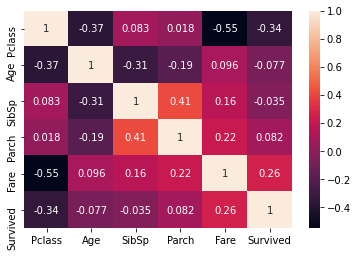

In [97]:
# 探查哪些特徵較適合做特徵組合
import seaborn as sns
import matplotlib.pyplot as plt

data = pd.concat([df, train_Y], axis=1)
plt.figure()
sns.heatmap(data.corr(), annot=True)

在相關性分析中，數值型特徵Pclass與Fare與目標值較為相關，可能對於預測能力較為好



In [98]:
# 類別型特徵與目標值:卡方檢定
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
# 取類別型特徵
objective_feature = []
for dtype, feature in zip(df.dtypes, df.columns):
  if dtype == 'object':
    objective_feature.append(feature)
print('類別型特徵有:{}'.format(objective_feature))

類別型特徵有:['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']


In [99]:
# Embarked與Survived是否有關(p value<0.05，即拒絕H0，Embarked與Survived相關)

Contingency_Table = data.groupby(by=['Embarked', 'Survived']).count()['Pclass'].reset_index()
Contingency_Table = Contingency_Table.rename(columns={'Pclass':'Counts'})
Contingency_Table.head(7)

,Embarked,Survived,Counts
0,C,0,75
1,C,1,93
2,Q,0,47
3,Q,1,30
4,S,0,427
5,S,1,217


In [100]:
import numpy as np
import scipy.stats

obs = np.array([[75, 47, 427], [93, 30, 217]])
scipy.stats.chi2_contingency(obs, correction=False)

(26.48914983923762,
 1.769922284120912e-06,
 2,
 array([[103.7480315,  47.5511811, 397.7007874],
        [ 64.2519685,  29.4488189, 246.2992126]]))

In [101]:
# 取一個類別型欄位, 與一個數值型欄位, 做群聚編碼
"""
Your Code Here
"""
# 取Fare與Embarked做群聚編碼
df['Embarked'] = df['Embarked'].fillna('None')

mean_df = df.groupby(by='Embarked')['Fare'].mean().reset_index()
mode_df = df.groupby(['Embarked'])['Fare'].apply(lambda x:x.mode()[0]).reset_index()
median_df = df.groupby(['Embarked'])['Fare'].median().reset_index()
max_df = df.groupby(['Embarked'])['Fare'].max().reset_index()
min_df = df.groupby(['Embarked'])['Fare'].min().reset_index()

temp = pd.merge(mean_df, mode_df, on=['Embarked'], how='left')
temp = pd.merge(temp, median_df, on=['Embarked'], how='left')
temp = pd.merge(temp, max_df, on=['Embarked'], how='left')
temp = pd.merge(temp, min_df, on=['Embarked'], how='left')

temp.columns = ['Embarked', 'Fare_mean', 'Fare_mode', 'Fare_median', 'Fare_max', 'Fare_min']

temp

,Embarked,Fare_mean,Fare_mode,Fare_median,Fare_max,Fare_min
0,C,59.954144,7.2292,29.70,512.3292,4.0125
1,None,80.000000,80.0000,80.00,80.0000,80.0000
2,Q,13.276030,7.7500,7.75,90.0000,6.7500
3,S,27.079812,8.0500,13.00,263.0000,0.0000


In [102]:
df_temp = pd.merge(df, temp, on=['Embarked'], how='left')
df_temp = df_temp.drop(['Embarked'], axis=1)
df_temp.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Fare_mean,Fare_mode,Fare_median,Fare_max,Fare_min
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,27.079812,8.0500,13.0,263.0000,0.0000
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,59.954144,7.2292,29.7,512.3292,4.0125
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,27.079812,8.0500,13.0,263.0000,0.0000
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,27.079812,8.0500,13.0,263.0000,0.0000
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,27.079812,8.0500,13.0,263.0000,0.0000


In [81]:
#只取 int64, float64 兩種數值型欄位, 存於 num_features 中
num_features = []
for dtype, feature in zip(df_temp.dtypes, df_temp.columns):
    if dtype == 'float64' or dtype == 'int64':
        num_features.append(feature)
print(f'{len(num_features)} Numeric Features : {num_features}\n')

# 削減文字型欄位, 只剩數值型欄位
df_temp = df_temp[num_features]
df_temp = df_temp.fillna(-1)
MMEncoder = MinMaxScaler()
df_temp.head()

10 Numeric Features : ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Fare_mean', 'Fare_mode', 'Fare_median', 'Fare_max', 'Fare_min']



,Pclass,Age,SibSp,Parch,Fare,Fare_mean,Fare_mode,Fare_median,Fare_max,Fare_min
0,3,22.0,1,0,7.2500,27.079812,8.0500,13.0,263.0000,0.0000
1,1,38.0,1,0,71.2833,59.954144,7.2292,29.7,512.3292,4.0125
2,3,26.0,0,0,7.9250,27.079812,8.0500,13.0,263.0000,0.0000
3,1,35.0,1,0,53.1000,27.079812,8.0500,13.0,263.0000,0.0000
4,3,35.0,0,0,8.0500,27.079812,8.0500,13.0,263.0000,0.0000


# 作業2
* 將上述的新特徵，合併原有的欄位做生存率預估，結果是否有改善?

In [103]:
df.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    int64  
 1   Name      891 non-null    object 
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Ticket    891 non-null    object 
 7   Fare      891 non-null    float64
 8   Cabin     204 non-null    object 
 9   Embarked  891 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 69.7+ KB


In [69]:
# 原始特徵 + 邏輯斯迴歸
"""
Your Code Here
"""
df_orig = df.copy()
df_orig_feature = df_orig.columns
df_orig['Age'] = df_orig['Age'].fillna(-1)
df_orig['Cabin'] = df_orig['Cabin'].fillna('None')
for c in objective_feature:
  df_orig[c] = le.fit_transform(df_orig[c])
df_orig = MMEncoder.fit_transform(df_orig)

print('目前訓練的特徵:{}'.format(df_orig_feature))
print('orig_feature_logistic_score:{}'.format(cross_val_score(LogisticRegression(), df_orig, train_Y, cv=5).mean()))


目前訓練的特徵:Index(['Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare',
       'Cabin', 'Embarked'],
      dtype='object')
orig_feature_logistic_score:0.788977465319189


In [82]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Pclass       891 non-null    int64  
 1   Age          891 non-null    float64
 2   SibSp        891 non-null    int64  
 3   Parch        891 non-null    int64  
 4   Fare         891 non-null    float64
 5   Fare_mean    891 non-null    float64
 6   Fare_mode    891 non-null    float64
 7   Fare_median  891 non-null    float64
 8   Fare_max     891 non-null    float64
 9   Fare_min     891 non-null    float64
dtypes: float64(7), int64(3)
memory usage: 76.6 KB


In [92]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Pclass       891 non-null    int64  
 1   Name         891 non-null    object 
 2   Sex          891 non-null    object 
 3   Age          714 non-null    float64
 4   SibSp        891 non-null    int64  
 5   Parch        891 non-null    int64  
 6   Ticket       891 non-null    object 
 7   Fare         891 non-null    float64
 8   Cabin        204 non-null    object 
 9   Fare_mean    891 non-null    float64
 10  Fare_mode    891 non-null    float64
 11  Fare_median  891 non-null    float64
 12  Fare_max     891 non-null    float64
 13  Fare_min     891 non-null    float64
dtypes: float64(7), int64(3), object(4)
memory usage: 104.4+ KB


In [104]:
# 新特徵 + 邏輯斯迴歸
"""
Your Code Here
"""
df_temp_feature = df_temp.columns
df_temp['Age'] = df_temp['Age'].fillna(-1)
df_temp['Cabin'] = df_temp['Cabin'].fillna('None')
for dtype, feature in zip(df_temp.dtypes, df_temp.columns):
  if dtype == 'object':
    df_temp[feature] = le.fit_transform(df_temp[feature])

df_temp = MMEncoder.fit_transform(df_temp)
print('目前訓練的特徵:{}'.format(df_temp_feature))
print('New_feature_logistic_score:{}'.format(cross_val_score(LogisticRegression(), df_temp, train_Y, cv=5).mean()))


目前訓練的特徵:Index(['Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare',
       'Cabin', 'Fare_mean', 'Fare_mode', 'Fare_median', 'Fare_max',
       'Fare_min'],
      dtype='object')
New_feature_logistic_score:0.7844893603665809


加入新特徵後，結果並無改善